In [1]:
from IPython.display import Image

## Note 6: Autoencoders
#### This material is mainly aiming to crystallize my knowledge. Any suggestion or correction would be gladly accepted
<br>
The idea behind autoencoders is rather simple. They are used as a dimensionality reduction method which learns compressed and meaningful representation also called latent representation or code.

The code is a compression of the original data and which contains feature representation, Unlike PCA, another dimensionality reduction method, auto-encoders are not using linear transformation meaning implying several drawbacks such as:

- data specific, not able to generalize on a completely new type of data
- lossy: lose information about the original data 
- Unsupervised
<br><br>
Although they seem to be less efficient than other methods because of the drawbacks cited above, they are useful in specific cases such as:
- data denoising
- dimensionality reduction and latent representation od complex data wich lack linear feature representation
3. variational auto encoders VAE learning parameters of probability distribution instead of arbitrary function
<br><br>

Auto-encoders are composed of three parts: encoder, code, decoders. encoders and decoders are symmetric on each side of the code and during training, the network learns to output the closest clone of the inputs as possible using loss functions such as L2. This implying that the ground truths are actually inputs themselves. 
<br>img above from https://goo.gl/WE3eD1
<br><br>
![Autoencoder_structure](ims/Autoencoder_structure.png)

<br><br>
The following methods are used to improve the latent representation contained in the code:
- Keeping the code small force the autoencoder to learn meaningful representation and avoid the model to just learn to map specific code to specific output caused by overfitting.
- Adding noise into the input data is also a good way to regularize them and force them to learn better representations.
- Sparse encoders using activity regulariser have proven to be a successful way to learn better latent representations

## Practice
My next note which will focus on GAN and cGAN so instead of building an FC autoencoder, I will use a convnet which in that case which will reduce mnist dataset data from a 28\*28 size to a code with a size of 7*7. 

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers as KL
import matplotlib.pyplot as plt

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x = x_train / 255.0
x = np.expand_dims(x, axis = -1)
x.shape, np.min(x), np.max(x)

((60000, 28, 28, 1), 0.0, 1.0)

In [12]:
def get_dataset(x):
    '''Instanciate dataset
    '''
    dataset = tf.data.Dataset.from_tensor_slices((x, x))
    dataset = dataset.repeat()
    return dataset.batch(32)


def encoding_layer(x, filters):
    """downsampling Layers used for the encoder 
    """
    x = KL.SeparableConv2D(filters, kernel_size=4, padding='same')(x)
    X = tf.keras.activations.relu(x)
    X = KL.BatchNormalization()(x)
    x = KL.MaxPooling2D((2, 2))(x)

    return x


def decoding_layer(layer_input, skip_input, filters):
    """Upsampling Layers used for the decoder
    """
    x = KL.UpSampling2D(size=2)(layer_input)
    x = KL.SeparableConv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(x)
    x = KL.BatchNormalization(momentum=0.8)(x)
    x = KL.Concatenate()([x, skip_input])
    return x


def get_callbacks():
    '''Reduce the learning rate when the mae metric doesn't improve
    '''
    return [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='mean_absolute_error', factor=0.2,
                              patience=5, min_lr=0.00001, verbose = 1)
    ]


def compile_model(model):
    '''Compile model
    '''
    model.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['mae'])


def autoencoder():
    '''Build the autoencoder
    '''
    x0 = tf.keras.Input(shape=(28,28, 1))

    # #encoding
    e1 = encoding_layer(x0, 32)
    e2 = encoding_layer(e1, 1)

    # #decoding
    d1 = decoding_layer(e2, e1, 32)
    d2 = KL.UpSampling2D(size=2)(d1)
    output = KL.Conv2D(1, strides=1,kernel_size=4, padding='same', activation='relu')(d2)
    
    return tf.keras.Model(x0, output)

In [13]:
model = autoencoder()
compile_model(model)
dataset = get_dataset(x)

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
separable_conv2d_9 (SeparableCo (None, 28, 28, 32)   80          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 32)   0           separable_conv2d_9[0][0]         
__________________________________________________________________________________________________
separable_conv2d_10 (SeparableC (None, 14, 14, 1)    545         max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
max_poolin

In [20]:
h = model.fit(dataset, epochs=30, steps_per_epoch=600, callbacks = get_callbacks())

In [21]:
preds = []

for i in range(10):
    preds.append(np.squeeze(x[i]))
    r = model.predict(np.expand_dims(x[i], axis = 0))
    r = np.squeeze(r)
    preds.append(r)

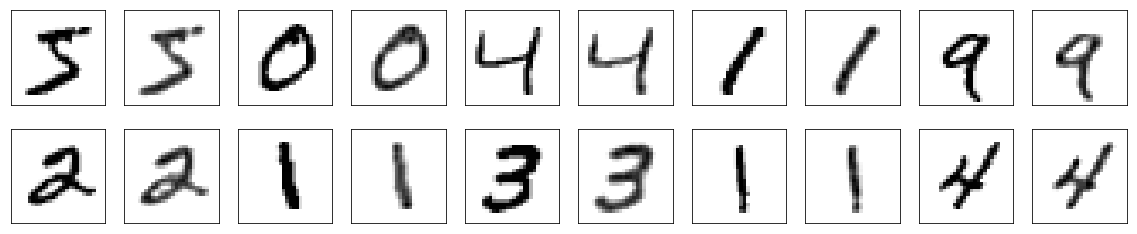

In [17]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i], cmap=plt.cm.binary)
    
plt.show()

#### Note:
We can see that we apply a dimensional reduction of 4 on the mnist dataset. We could use separately the first half of the model to encode data and the other half to decode them. Use case: So far, the best use case I can think of is to learn non-linear feature representations from a dataset before to use them as an input of another network. 

<br><br>
# Resources

**Computerphile** - Encoder Decoder Network https://goo.gl/pdvo2G
<br><br>
**Siraj Raval** - Autoencoder Explained https://goo.gl/SVqUK5
<br><br>
**Rohan Saxena** - What is an Encoder/Decoder in Deep Learning? https://goo.gl/6NoZ2F
<br><br>
**Tensorflow** - Variational Autoencoders with Tensorflow Probability Layers https://goo.gl/88JPMK
<br><br>
**Thomas Ciha** - PCA & Autoencoders: Algorithms Everyone Can Understand https://goo.gl/UTXfbj
<br><br>
**Andrew Ng** - cs294a Sparse Autoencoder Lecture Part 1 https://goo.gl/VwvNVf
<br><br>
**Andrew Ng** - cs294a Sparse Autoencoder Lecture Part 2 https://goo.gl/tv4Ged
<br><br>
**Ali Ghodsi, Lec** - Deep Learning, Variational Autoencoder, Oct 12 2017 [Lect 6.2] https://goo.gl/ywFmuQ
<br><br>
**Arden Dertat** - Applied Deep Learning - Part 3: Autoencoders https://goo.gl/dfdyyp
<br><br>
**Kevin Frans** - Variational Autoencoders Explained https://goo.gl/q8c7QT
<br><br>

### Papers
<br><br>
**Auto-Encoding Variational Bayes** https://arxiv.org/abs/1312.6114